In [5]:
import tensorflow as tf
import random
import numpy as np
import os
from dataclasses import dataclass
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import zipfile
import requests
import glob as glob

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)

# Text formatting.
bold = "\033[1m"

# Fix seeds for reproducibility.
SEED_VALUE = 2000

random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [7]:
def system_config():

    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)

    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')

        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)

        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config()

[]
Using CPU


In [8]:
import os

# Define the directory path
root_dir = 'D:\\tmp\\Andrea\\train\\train'

# Initialize an empty dictionary to store labels
labels = {}
label_counter = 0

def traverse_directory(directory):
    global label_counter
    global labels

    # Get a list of subfolders and files
    contents = os.listdir(directory)

    image_found = False

    for item in contents:
        item_path = os.path.join(directory, item)

        # Check if item is a subfolder
        if os.path.isdir(item_path):
            # Recursively traverse subfolders
            traverse_directory(item_path)

        # Check if item is an image file
        if os.path.isfile(item_path) and item.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_found = True

    # Add label if an image was found
    if image_found:
        # Get relative directory path (excluding root_dir)
        rel_dir = os.path.relpath(directory, root_dir)

        labels[label_counter] = rel_dir
        label_counter += 1
#        print(f"Label {label_counter-1}: {rel_dir}")


# Start traversing from the root directory
traverse_directory(root_dir)

categories = []
# Save labels to a file (optional)
with open('labels.txt', 'w') as f:
    for key, value in labels.items():
        f.write(f"{key}: {value}\n")
        categories.append(value)

print("Labels created successfully.")
print(categories)

Labels created successfully.
['Camisas', 'Carteras', 'Chalecos y sacos', 'Cinturones', 'Lentes', 'Mochilas', 'Pantalones', 'Polos y playeras', 'ZapatoDeportivo']


In [9]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES:  int = 9
    IMG_HEIGHT:   int = 628
    IMG_WIDTH:    int = 442
    NUM_CHANNELS: int = 3
    BATCH_SIZE:   int = 32
    DATA_ROOT:    str = 'D:\\tmp\\Andrea'

data_config = DatasetConfig()

# Set data paths.
train_path = os.path.join(data_config.DATA_ROOT, "train\\train")
valid_path = os.path.join(data_config.DATA_ROOT, "test")

In [10]:
print(train_path)
print(valid_path)

D:\tmp\Andrea\train\train
D:\tmp\Andrea\test


In [11]:
input_shape = (data_config.IMG_HEIGHT, data_config.IMG_WIDTH)
batch_size = data_config.BATCH_SIZE

train_dataset = image_dataset_from_directory(directory=train_path,
                                             image_size=input_shape,
                                             color_mode='rgb',
                                             batch_size=batch_size,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                            )

valid_dataset = image_dataset_from_directory(directory=valid_path,
                                             image_size=input_shape,
                                             color_mode='rgb',
                                             batch_size=batch_size,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                            )

Found 431 files belonging to 9 classes.
Found 151 files belonging to 9 classes.


In [12]:
# Print the shape of the data and the aassociated labels.
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 628, 442, 3)
labels batch shape: (32, 9)


In [13]:
# You can use the object attribute (class_names) to access the class names in the dataset.
valid_dataset.class_names

['Camisas',
 'Carteras',
 'Chalecos y sacos',
 'Cinturones',
 'Lentes',
 'Mochilas',
 'Pantalones',
 'Polos y playeras',
 'ZapatoDeportivo']

### 2.4 Display Sample Images from Dataset

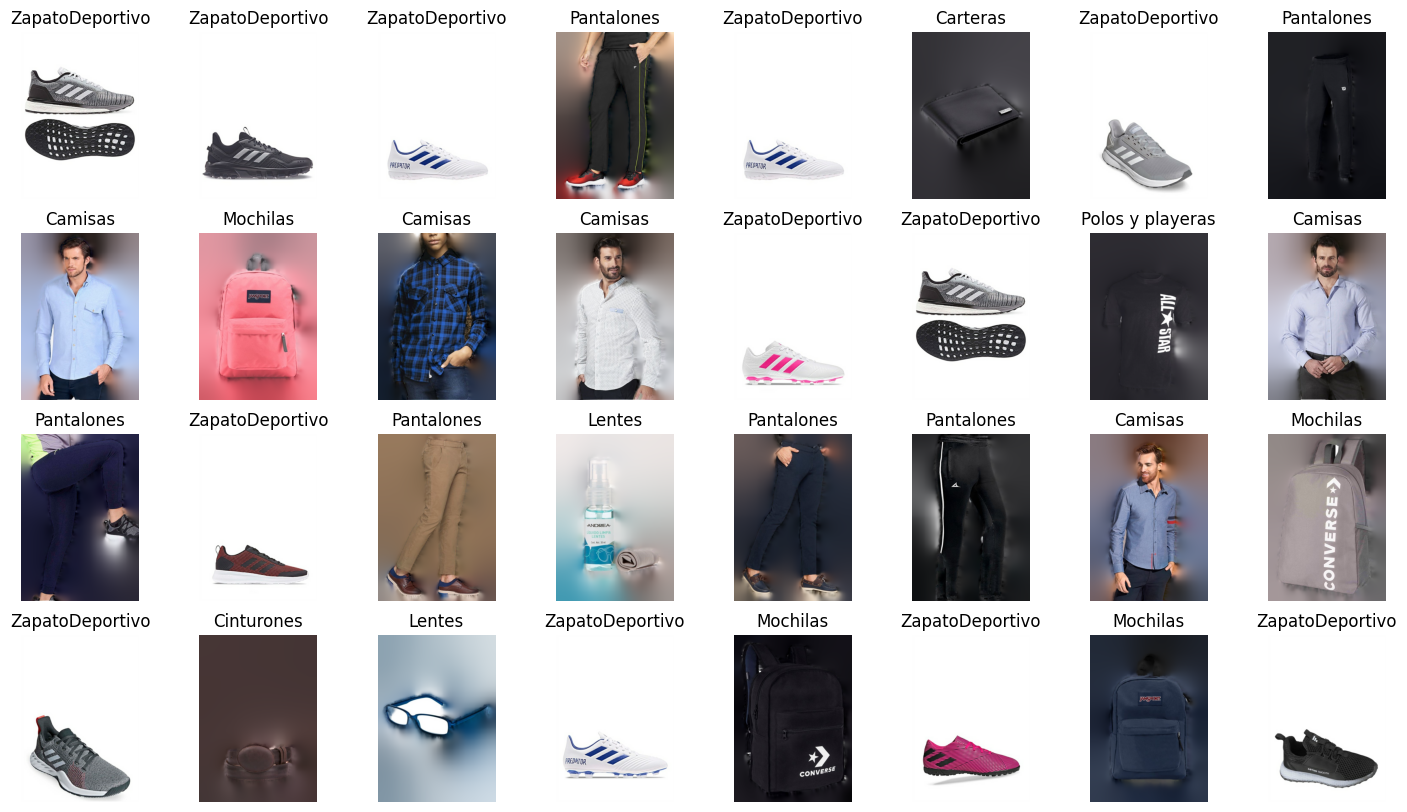

In [24]:
class_names = train_dataset.class_names

plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1):

    # For the batch of images and the associated (one-hot encoded) labels,
    # plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = np.nonzero(labels_batch[i].numpy())
        plt.title(class_names[truth_idx[0][0]])
        plt.axis("off")

plt.savefig('images/sample_images.png')


### 3.1 Define the Model

This is the CNN model that we introduced in the previous notebook. Let's train this model again for a larger number of epochs to show that it overfits the training data.

## To be tested

Batch Normalization:
Batch normalization is a technique that normalizes the input data for each layer, which helps to:
Reduce internal covariate shift: Batch normalization reduces the change in the distribution of the input data as it flows through the network. This helps to stabilize the training process.
Improve gradient flow: By normalizing the input data, batch normalization helps to improve the flow of gradients through the network, which can lead to faster and more stable training.
Regularize the model: Batch normalization can also be seen as a form of regularization, as it adds noise to the input data during training.
In your case, adding batch normalization after each convolutional layer can help to:
Reduce overfitting
Improve the stability of the training process
Possibly improve the accuracy of the model
Dropout:
Dropout is a regularization technique that randomly sets a fraction of the neurons in a layer to zero during training. This helps to:
Prevent overfitting: By randomly dropping out neurons, dropout prevents the model from relying too heavily on any single neuron or group of neurons.
Encourage feature sharing: Dropout encourages the model to learn multiple representations of the data, which can help to improve the model's ability to generalize.
In your case, adding dropout after each convolutional layer and after the fully connected layer can help to:
Reduce overfitting
Improve the model's ability to generalize
Possibly improve the accuracy of the model

In [22]:
# Model alternative

def cnn_model2(input_shape=(628, 442, 3), num_classes=9):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [25]:
# Define the model.
#def cnn_model(input_shape=(224, 224, 3), num_classes=10):
def cnn_model(input_shape=(628, 442, 3), num_classes=9):

    #----------------------------------------------
    # Input layer and Conv Block 1: 32-32-MaxPool.
    #----------------------------------------------
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 2: 64-64-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 3: 128-128-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 4: 256-256-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    x = layers.Flatten()(x)

    # Fully connected layers.
    x = layers.Dense(512, activation='relu')(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [26]:
model = cnn_model(num_classes=data_config.NUM_CLASSES)

### 3.2 Set Training Configuration Parameters

In [27]:
@dataclass(frozen=True)
class TrainingConfig:
#    EPOCHS:             int   = 51
    EPOCHS:             int   = 20
    LEARNING_RATE:      float = 0.001

training_config = TrainingConfig()

### 3.3 Compile and Train the Model

In [28]:
import tensorflow as tf

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)

In [29]:
# Compile the model.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=training_config.LEARNING_RATE),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [28]:
training_results = model.fit(train_dataset,
                             validation_data=valid_dataset,
                             epochs=training_config.EPOCHS,
                             callbacks=[early_stopping])

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 264s 19s/step - accuracy: 0.2556 - loss: 4.3158 - val_accuracy: 0.3974 - val_loss: 1.7120
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 292s 21s/step - accuracy: 0.5039 - loss: 1.4883 - val_accuracy: 0.6291 - val_loss: 1.3112
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 304s 22s/step - accuracy: 0.6636 - loss: 1.0382 - val_accuracy: 0.5960 - val_loss: 1.1630
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 299s 21s/step - accuracy: 0.7552 - loss: 0.7499 - val_accuracy: 0.7020 - val_loss: 0.9313
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 311s 22s/step - accuracy: 0.7915 - loss: 0.6668 - val_accuracy: 0.7152 - val_loss: 1.1243
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 292s 21s/step - accuracy: 0.7976 - loss: 0.5997 - val_accuracy: 0.7748 - val_loss: 0.8004
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 307s 22s/step - accuracy: 0.8355 - loss: 0.5421 - val_accuracy: 0.7881 - val_loss: 0.6085
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 302s 22s/step - accuracy: 0.9001 - loss: 0.3065 - val_accuracy: 0.

In [ ]:
# Train the model.
training_results = model.fit(train_dataset,
                             validation_data=valid_dataset,
                             epochs=training_config.EPOCHS,
#                             workers=4,
#                             use_multiprocessing=True,
                             )

# Plot the training result

In [30]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, training_config.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    name = "_".join([s.lower().replace(" ", "_") for s in metric_name]) + ".jpg"
    print(name)
    plt.savefig(name)
    plt.show(block=block_plot)
    plt.close()

training_accuracy_validation_accuracy.jpg


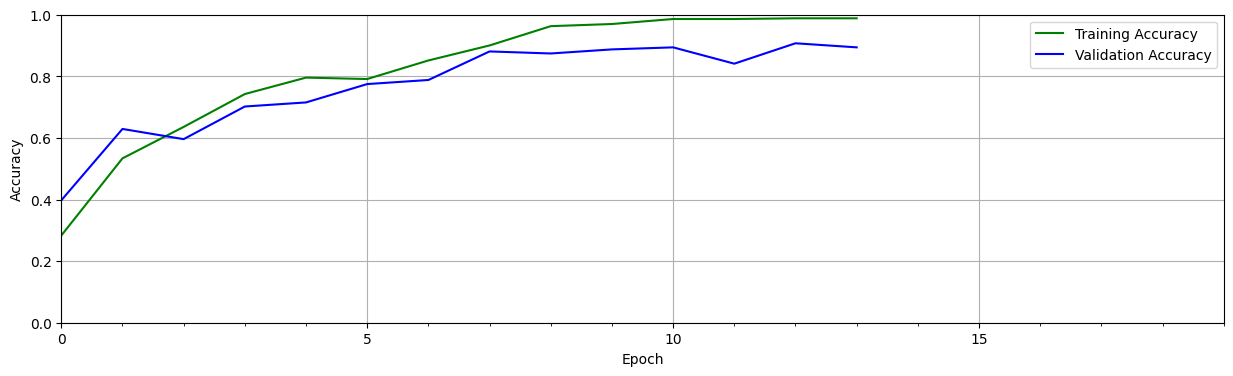

training_loss_validation_loss.jpg


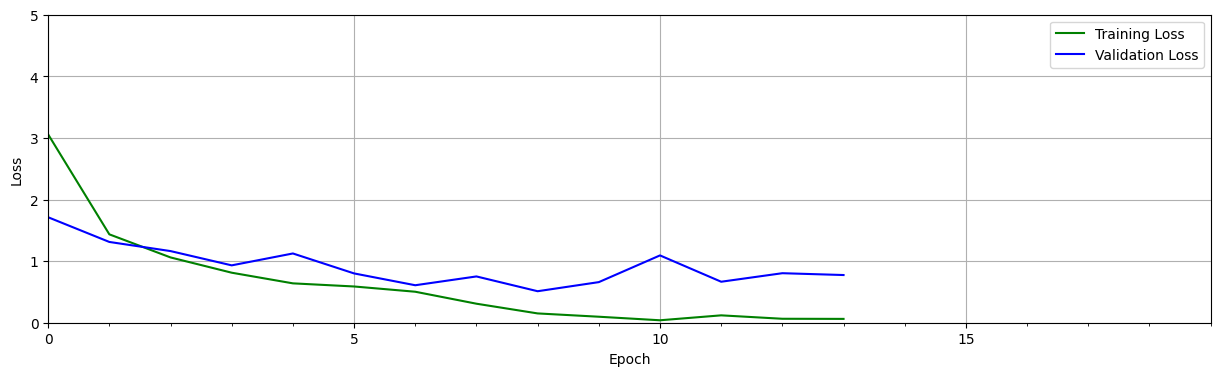

In [43]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

In [45]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 628, 442, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 628, 442, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 628, 442, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 628, 442, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 314, 221, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 314, 221, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 314, 221, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 157, 110, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 157, 110, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 157, 110, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 78, 55, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 78, 55, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 78, 55, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 39, 27, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 269568)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     138,019,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 417,588,605 (1.56 GB)

 Trainable params: 139,196,201 (530.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 278,392,404 (1.04 GB)

# Evaluate Model

Here, we will define a function that will call the `predict()` method on a portion of the validation dadaset, just so we can visualize the results on some of the images.

In [34]:
def evaluate_model(dataset, model):

    num_matches = 0
    plt.figure(figsize=(17, 12))
    num_rows = 5
    num_cols = 6
    class_names = dataset.class_names

    # Retrieve a single batch.
    for data_batch, labels_batch in dataset.take(1):
        predictions = model.predict(data_batch)

        for idx in range(num_rows*num_cols):
            ax = plt.subplot(num_rows, num_cols, idx + 1)
            plt.axis("off")
            plt.imshow(data_batch[idx].numpy().astype("uint8"))

            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = np.nonzero(labels_batch[idx].numpy())

            title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
            title_obj = plt.title(title, fontdict={'fontsize':11})

            if pred_idx == truth_idx:
                num_matches += 1
                plt.setp(title_obj, color='g')
            else:
                plt.setp(title_obj, color='r')

            acc = num_matches/(idx+1)
        print("Prediction accuracy: ", int(100*acc)/100)
    
    plt.savefig('images/eval.png')

    return

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction accuracy:  0.96


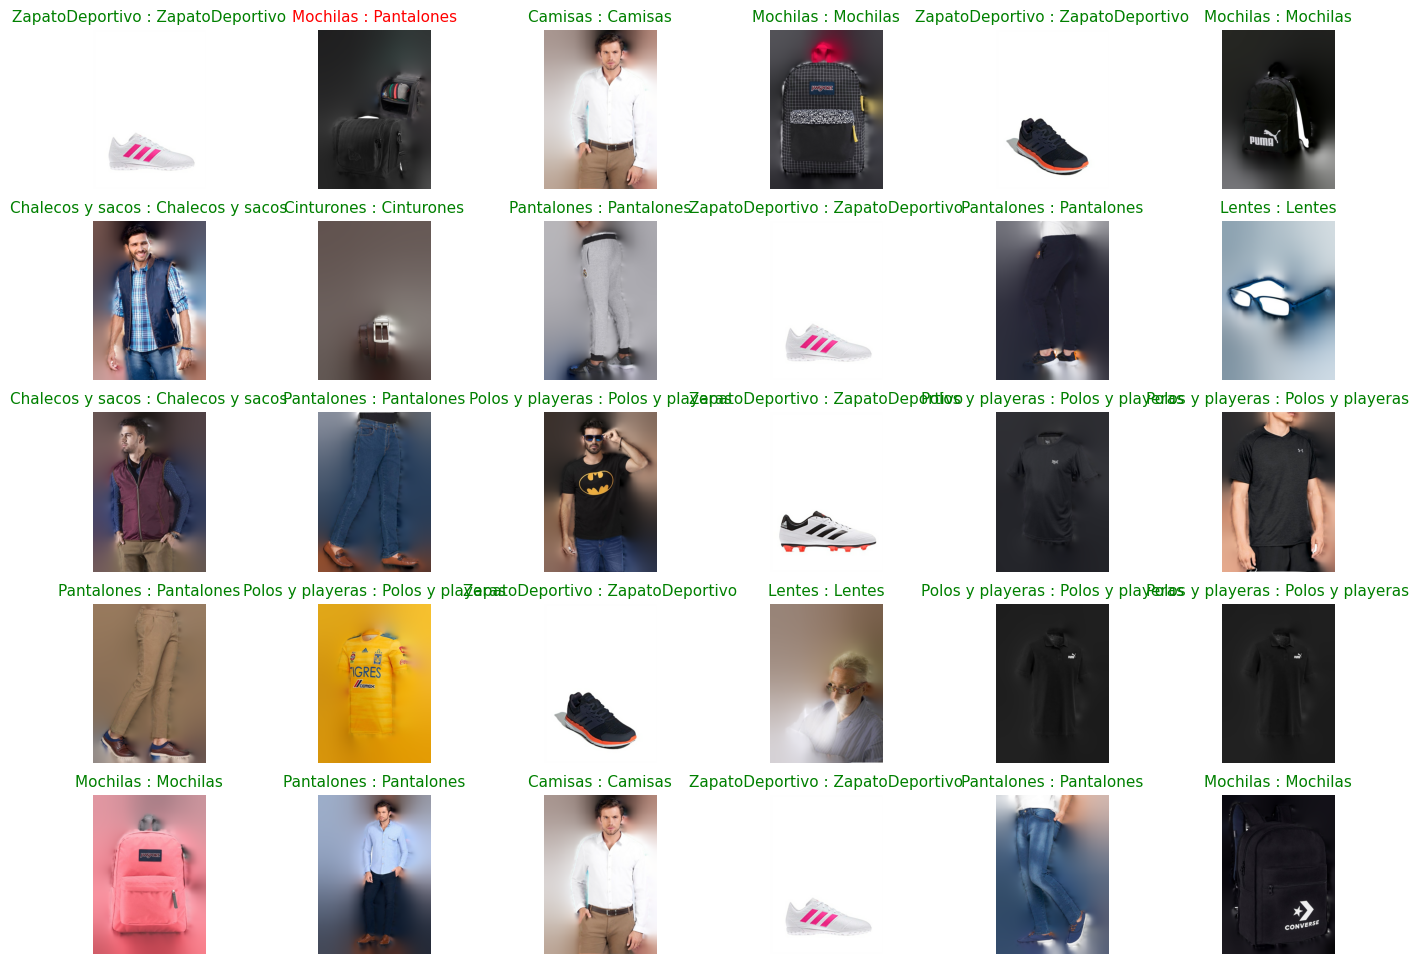

In [133]:
evaluate_model(valid_dataset, model)

In [134]:
model.save('cnn_model.h5')
#keras.saving.save_model(model)
model.save('cnn_model.keras')


In [146]:
#keras.saving.save_model(model, 'cnn_model.keras')
#tf.keras.models.save_model(model, 'cnn_model.h5', save_format='h5')
#tf.saved_model.save(model, 'cnn_model')
#tf.keras.models.save_model(model, 'cnn_model.h5')
tf.keras.models.save_model(model, 'cnn_model.keras')


In [32]:
# Load the saved model

loaded_model = keras.models.load_model('cnn_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction accuracy:  0.96


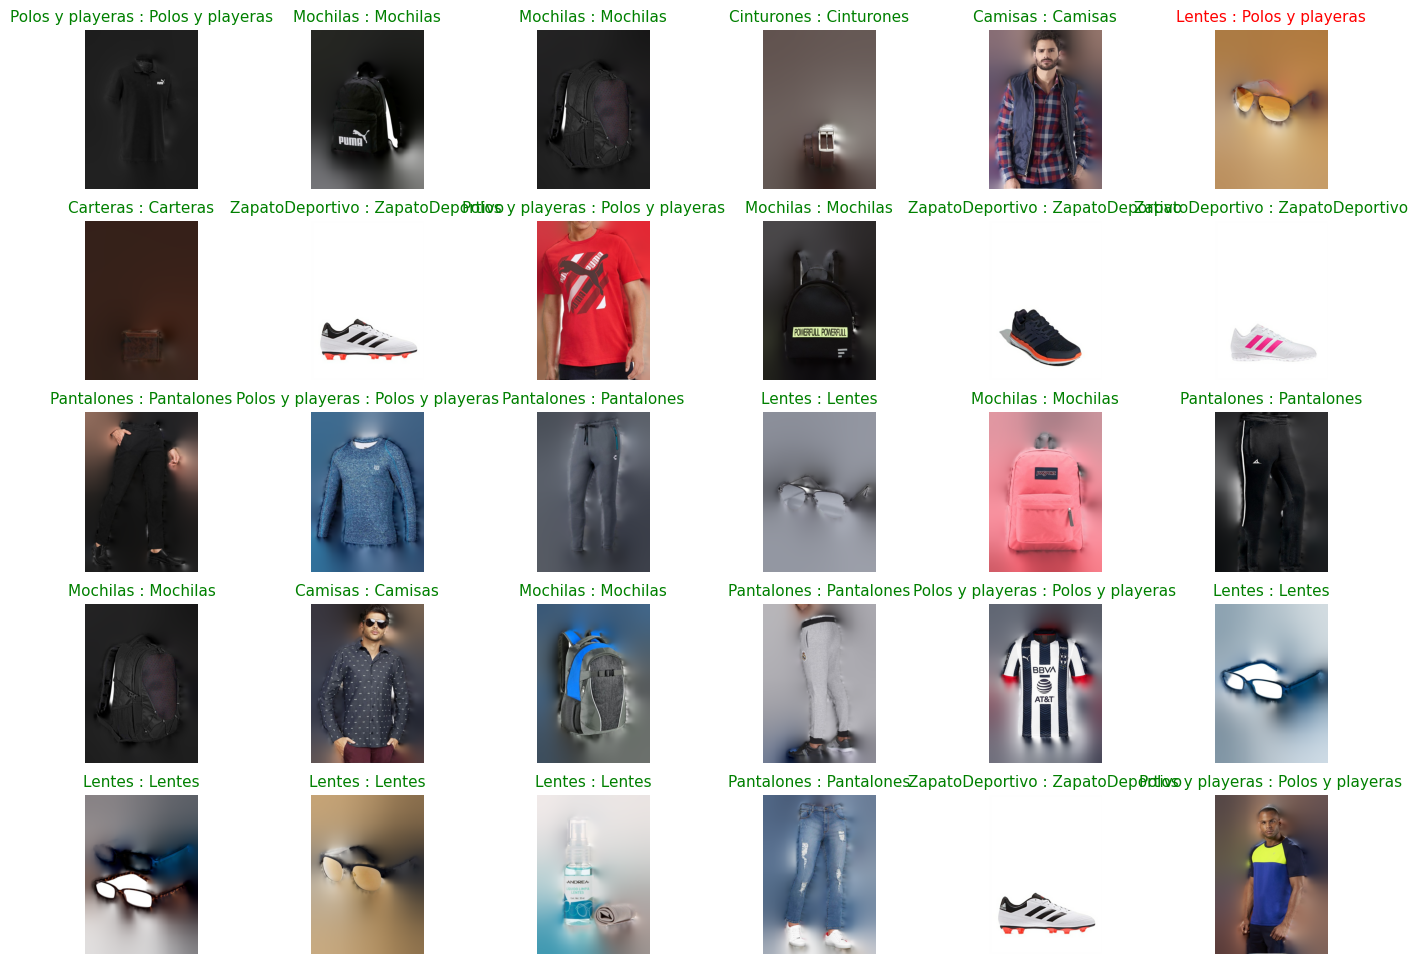

In [38]:
evaluate_model(valid_dataset, loaded_model)

In [230]:
loaded_model = keras.models.load_model('cnn_model.h5')


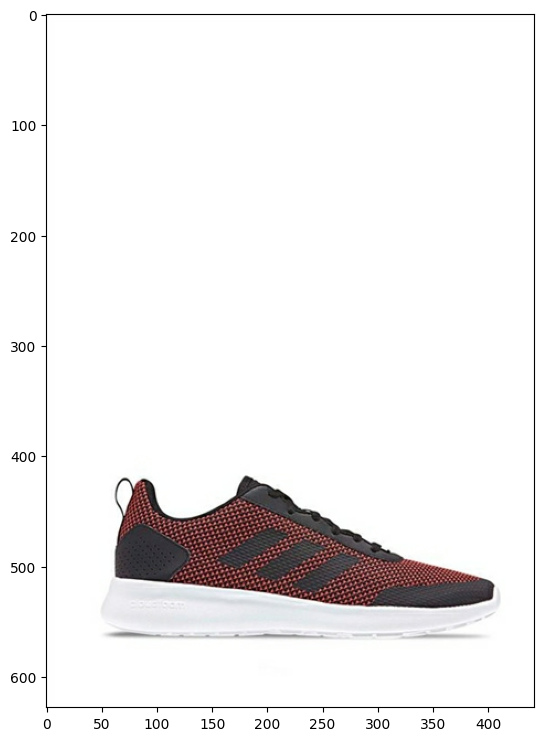

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Predicted Class: tf.Tensor(8, shape=(), dtype=int64)
Predicted Class: ZapatoDeportivo
valid_class: ZapatoDeportivo
Predicted Probabilities: [6.6257369e-21 0.0000000e+00 1.2210658e-19 2.0010898e-29 9.6442501e-29
 2.9830476e-22 2.9510938e-16 2.0586471e-24 1.0000000e+00]


In [151]:
# Load the saved model


# Load the new image
new_image = tf.io.read_file('test/Camisas/CAMISASAZUL14035580_masked.jpg')
new_image = tf.io.read_file("test/Carteras/BOLSACAFE1451771UNI_masked.jpg")
#new_image = tf.io.read_file("test/Chalecos y sacos/CHALECOSMULTICOLOR14718781_masked.jpg")
#new_image = tf.io.read_file("test/Chamarras y abrigos/CHAMARRAABRIGOSGRIS14625310_masked.jpg")
#new_image = tf.io.read_file("test/Cinturones/CINTURONAZULMARINO14109900_masked.jpg")
#new_image = tf.io.read_file("test/Jeans/JEANSAZUL14718300_masked.jpg")
#new_image = tf.io.read_file("test/Chalecos y sacos/CHALECOSMULTICOLOR14718781_masked.jpg")
#new_image = tf.io.read_file('D:\\tmp\\Andrea\\test\\ZapatoDeportivo\\ADIDASGALAXY4AZULMARINO26877280.jpg')
new_image = tf.io.read_file('D:\\tmp\\Andrea\\train\\train\\ZapatoDeportivo\\ADIDASARGECYROJO26715430.jpg')
#new_image = tf.io.read_file('D:\\tmp\\Andrea\\test\\Camisas\\CAMISASAZUL14035723_masked.jpg')

new_image = tf.image.decode_jpeg(new_image, channels=3)

prt_img = tf.dtypes.cast(new_image, new_image.dtype)

# Plot the uploaded image
# Plot the uploaded image with transparent background
plt.imshow(prt_img)
#plt.axis('off')  # Turn off axis
#plt.gca().set_axis_off()  # Turn off axis
#plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)
plt.show()
# Preprocess the image
new_image = tf.image.resize(new_image, (628, 442))
#new_image = new_image / 255.0

# Convert to tensor
new_image = tf.expand_dims(new_image, axis=0)

# Make predictions
#predictions = loaded_model.predict(new_image)
predictions = model.predict(new_image)

# Print the predicted class
#predicted_class = tf.argmax(predictions, axis=1)
#print(predicted_class)
predicted_probabilities = predictions[0]
predicted_class = tf.argmax(predicted_probabilities)
#
print("Predicted Class:", predicted_class)
print("Predicted Class:", valid_dataset.class_names[predicted_class.numpy()])
valid_class = valid_dataset.class_names[predicted_class.numpy()]
print("valid_class:",valid_class)
print("Predicted Probabilities:", predicted_probabilities)

In [169]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 628, 442, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [152]:
def check_model(dataset):

    num_matches = 0
    plt.figure(figsize=(17, 12))
    num_rows = 5
    num_cols = 6
    class_names = dataset.class_names

    # Retrieve a single batch.
    for data_batch, labels_batch in dataset.take(1):
        for idx in range(num_rows*num_cols):
            truth_idx = np.nonzero(labels_batch[idx].numpy())
            print(class_names[truth_idx[0][0]])
check_model(train_dataset)
#check_model(valid_dataset)

ZapatoDeportivo
Mochilas
Lentes
Mochilas
Cinturones
Pantalones
ZapatoDeportivo
Pantalones
ZapatoDeportivo
Lentes
Mochilas
Mochilas
ZapatoDeportivo
ZapatoDeportivo
Mochilas
ZapatoDeportivo
ZapatoDeportivo
Lentes
Cinturones
Polos y playeras
ZapatoDeportivo
ZapatoDeportivo
ZapatoDeportivo
Lentes
ZapatoDeportivo
Cinturones
ZapatoDeportivo
ZapatoDeportivo
Polos y playeras
ZapatoDeportivo


<Figure size 1700x1200 with 0 Axes>

# Image detection and comparison

In [125]:
valid_dataset = image_dataset_from_directory(directory=valid_path,
                                             image_size=input_shape,
                                             color_mode='rgb',
                                             batch_size=batch_size,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                            )

Found 134 files belonging to 10 classes.


## Extract primary colors from image using Kmeans and removing the face (if present)

In [7]:
import os
import cv2
import pandas as pd
import dlib
import numpy as np
from sklearn.cluster import KMeans


def extract_primary_colors(img_path, n_colors):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("C:\\projects\\visual\\Console\\MOPDlib\\MOPDlib\\Models\\shape_predictor_68_face_landmarks.dat")
#    img = cv2.imread(img_path)
    img = cv2.resize(img_path, (628, 442))

    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    faces = detector(img[:, :, :3])
    
    # Eliminar la cara de la imagen
    for face in faces:
        landmarks = predictor(img[:, :, :3], face)
    
        # Unir los puntos de referencia faciales para crear la máscara
        points = []
        for n in range(1, 18):  # puntos de la barbilla
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            points.append((x, y))
        for n in range(18, 22):  # puntos de la ceja izquierda
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            points.append((x, y))
        for n in range(22, 23):  # puntos que unen las cejas
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            points.append((x, y))
        for n in range(22, 27):  # puntos de la ceja derecha
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            points.append((x, y))
        for n in range(27, 18, -1):  # puntos de la oreja derecha a la izquierda
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            points.append((x, y))

        # Rellenar la máscara con un color transparente
        hull = cv2.convexHull(np.array(points))
        mask = np.zeros(img.shape, dtype=np.uint8)
        cv2.drawContours(mask, [hull], 0, (0, 0, 0, 255), -1)
    
        # Eliminar la cara de la imagen
        img[mask[:, :, 3] == 255, 3] = 0
    
    # Reshape image to pixels
    pixels = img.reshape((-1, 3))

    # Remove pixels with low intensity
    pixels = pixels[np.any(pixels > 50, axis=1)]

    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(pixels)
    primary_colors = kmeans.cluster_centers_.astype(int)
    labels = kmeans.labels_

    # Contar la cantidad de píxeles para cada color
    color_counts = np.bincount(labels)

    # Ordenar los colores según la cantidad de píxeles
    sorted_indices = np.argsort(color_counts)[::-1]
    sorted_colors = primary_colors[sorted_indices]
    del detector
    del predictor

    return sorted_colors


## Create csv file with colours, names and classes for the training set

In [9]:


# Ruta raíz
root_dir = 'd:\\tmp\\Andrea\\'
n_colors = 4
# Ruta de entrenamiento
train_dir = os.path.join(root_dir, 'train\\train')

# Crear un conjunto de datos que incluya el nombre de la imagen y la clase
dataset = []
for clase in os.listdir(train_dir):
    clase_dir = os.path.join(train_dir, clase)
    if os.path.isdir(clase_dir):
        for archivo in os.listdir(clase_dir):
            imagen_path = os.path.join(clase_dir, archivo)
#            print(imagen_path)
            imagen = cv2.imread(imagen_path)
            colores_dominantes = extract_primary_colors(imagen, n_colors)
            dataset.append({
                'image_name': archivo,
                'category_name': clase,
#                'colors': colores_dominantes #colores_dominantes.tolist()  # Convertir a lista
                'colors': [color.tolist() for color in colores_dominantes]
            })

# Convertir el dataset a un pandas DataFrame
df = pd.DataFrame(dataset)

# Guardar el DataFrame como un archivo CSV
df.to_csv('colores_dominantes_dataset.csv', index=False)

## Implement CIE94 algorithm for colour comparison

In [3]:
import pandas as pd
import numpy as np


# Cargar la imagen de prueba
import math

def cie94_distance(color1, color2):
    # Convertir colores a CIE Lab
    lab1 = rgb_to_lab(color1)
    lab2 = rgb_to_lab(color2)

    # Calcular la distancia CIE94
    delta_e = math.sqrt(
        (lab1[0] - lab2[0]) ** 2 +
        (lab1[1] - lab2[1]) ** 2 +
        (lab1[2] - lab2[2]) ** 2
    )

    return delta_e


def rgb_to_lab(rgb):
    # Convertir RGB a XYZ
    xyz = [
        0.412453 * rgb[0] + 0.357580 * rgb[1] + 0.180423 * rgb[2],
        0.212671 * rgb[0] + 0.715160 * rgb[1] + 0.072169 * rgb[2],
        0.019334 * rgb[0] + 0.119193 * rgb[1] + 0.950227 * rgb[2]
    ]

    # Convertir XYZ a Lab
    lab = [
        116 * lab_f(xyz[1]) - 16,
        500 * (lab_f(xyz[0]) - lab_f(xyz[1])),
        200 * (lab_f(xyz[1]) - lab_f(xyz[2]))
    ]

    return lab


def lab_f(t):
    if t > 0.008856:
        return t ** (1/3)
    else:
        return 7.787 * t + 16/116

# Cargar la imagen de prueba
#imagen_prueba = cv2.imread('D:\\tmp\\Andrea\\train\\train\\Camisas\\CAMISASVINO14562710_masked.jpg')
imagen_prueba = cv2.imread('D:\\tmp\\Andrea\\train\\train\\Chalecos y sacos\\PUMAESSENTIALSPADDEDVESTNEGRO14848780_masked.jpg')
# Detectar los colores dominantes de la imagen de prueba
colores_dominantes_prueba = extract_primary_colors(imagen_prueba, 4)
# Cargar el archivo CSV
df = pd.read_csv('colores_dominantes_dataset.csv')


similitudes = []
    
for index, row in df.iterrows():
    colores = row['colors']
    colores = eval(colores)
    appended = False
    for color_prueba in colores_dominantes_prueba:
        for color in colores:
            color = np.array(color)
            similitud = cie94_distance(color, color_prueba)

            if similitud <= 15 and appended == False: #
                similitudes.append((index, row['image_name'], row['category_name'], similitud, color, color_prueba))
                appended = True
            else:
                continue

#similitudes_ordenadas = sorted(similitudes, key=lambda x: (x[2] != valid_class, x[3]))
similitudes_ordenadas = sorted(similitudes, key=lambda x: x[3], reverse=False)

# Imprimir todas las similitudes
for index, image_name, category_name, similitud, color, color_prueba in similitudes_ordenadas:
    print(f"Imagen: {image_name} - Clase: {category_name} - Similitud: {similitud:.2f} - Color: {color} - Color_prueba: {color_prueba}")

Imagen: PUMAESSPIQUEPOLONEGRO14328552_masked.jpg - Clase: Polos y playeras - Similitud: 1.68 - Color: [112 112 112] - Color_prueba: [111 111 111]
Imagen: PLAYERANEGRO14966970_masked.jpg - Clase: Polos y playeras - Similitud: 2.30 - Color: [70 70 70] - Color_prueba: [69 69 69]
Imagen: NEGRO14678713_masked.jpg - Clase: Polos y playeras - Similitud: 2.30 - Color: [70 69 69] - Color_prueba: [69 69 69]
Imagen: PUMAESSENTIALSPADDEDVESTNEGRO14848780_masked.jpg - Clase: Chalecos y sacos - Similitud: 2.32 - Color: [68 68 68] - Color_prueba: [69 69 69]
Imagen: ACTIVETRICOTPANTSCLNEGRO14701780_masked.jpg - Clase: Pantalones - Similitud: 2.50 - Color: [190 188 188] - Color_prueba: [189 189 189]
Imagen: DEPORTIVONEGRO27569051.jpg - Clase: ZapatoDeportivo - Similitud: 2.76 - Color: [192 191 191] - Color_prueba: [189 189 189]
Imagen: CAMISASBLANCO14793550_masked.jpg - Clase: Camisas - Similitud: 3.35 - Color: [192 191 192] - Color_prueba: [189 189 189]
Imagen: DEPORTIVONEGRO27569054.jpg - Clase: Zapa

In [4]:
df.head()

,image_name,category_name,colors
0,BOLSANEGROUNI13812902_masked.jpg,Camisas,"[[175, 164, 160], [217, 215, 215], [134, 112, ..."
1,CAMISASAZUL14035581_masked.jpg,Camisas,"[[106, 136, 173], [162, 196, 223], [77, 83, 10..."
2,CAMISASAZUL14035582_masked.jpg,Camisas,"[[116, 140, 171], [149, 122, 108], [174, 199, ..."
3,CAMISASAZUL14035724_masked.jpg,Camisas,"[[182, 202, 239], [174, 165, 180], [140, 122, ..."
4,CAMISASAZUL14036713_masked.jpg,Camisas,"[[112, 114, 137], [134, 101, 92], [67, 58, 62]..."


## Test colour comparison

NameError: name 'similitudes_ordenadas' is not defined

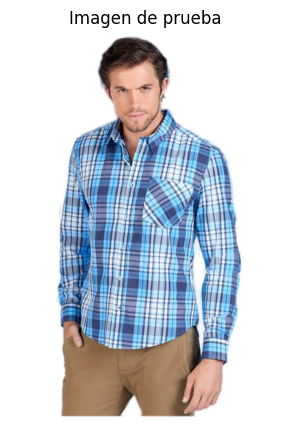

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Plotear la imagen de prueba
imagen_prueba_path = 'D:\\tmp\\Andrea\\train\\train\\Chalecos y sacos\\PUMAESSENTIALSPADDEDVESTNEGRO14848780_masked.jpg'

root_dir = 'd:\\tmp\\Andrea\\'
n_colors = 4
# Ruta de entrenamiento
train_dir = os.path.join(root_dir, 'train\\train')


img_prueba = mpimg.imread(imagen_prueba_path)
# Plotear la imagen de prueba y las imágenes similares
plt.figure(figsize=(30, 5))
plt.subplot(1, 6, 1)
plt.imshow(img_prueba)
plt.title("Imagen de prueba")
plt.axis('off')  # This will remove the axis

for i, (index, image_name, category_name, similitud, color, color_prueba) in enumerate(similitudes_ordenadas[:5]):
    image_path = os.path.join(train_dir, category_name, image_name)
    img = mpimg.imread(image_path)
    plt.subplot(1, 6, i+2)  # Start from 2 to account for the first image
    plt.imshow(img)
    plt.title(f"Imagen: \n{image_name} -\n Clase: {category_name} -\n Similitud: {similitud:.2f}")
    plt.axis('off')  # This will remove the axis

plt.tight_layout()
plt.savefig('images/test_colour.jpg')

plt.show()

## Deployment with class detected from image classification

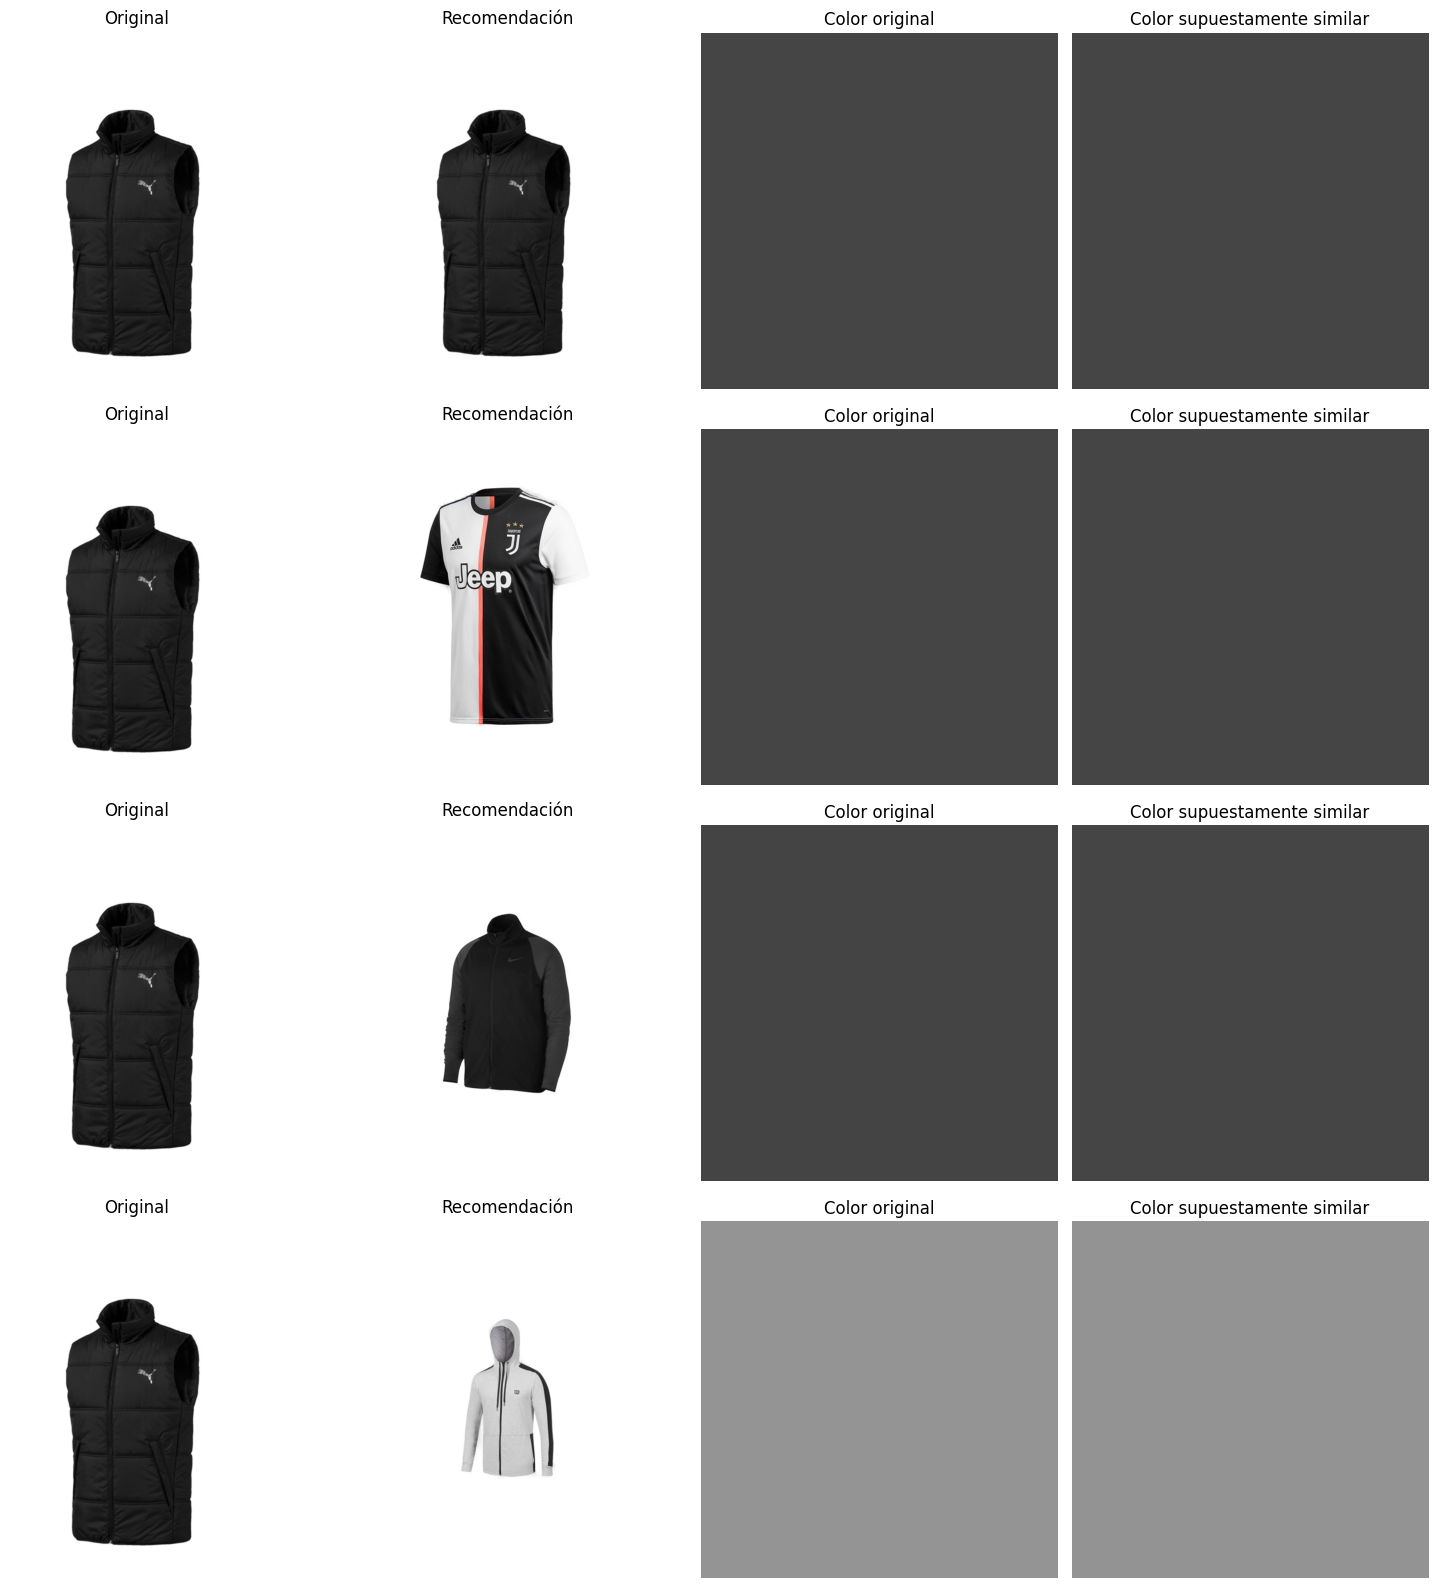

In [27]:
def display_image_colors(orig_image, image_path, color, color_prueba, axs):
    axs[0].imshow(mpimg.imread(orig_image))
    axs[0].set_title("Original")
    axs[0].axis('off')

    axs[1].imshow(mpimg.imread(image_path))
    axs[1].set_title("Recomendación")
    axs[1].axis('off')

    axs[2].imshow(np.full((80, 80, 3), color, dtype=np.uint8))
    axs[2].set_title("Color original")
    axs[2].axis('off')

    axs[3].imshow(np.full((80, 80, 3), color_prueba, dtype=np.uint8))
    axs[3].set_title("Color supuestamente similar")
    axs[3].axis('off')

# Plotear las imágenes similares
count = 0
num_filas = 4
fig, axs = plt.subplots(num_filas, 4, figsize=(15, 4 * num_filas))
for index, image_name, category_name, similitud, color, color_prueba in similitudes_ordenadas:
    image_path = os.path.join(train_dir, category_name, image_name)
    display_image_colors(imagen_prueba_path, image_path, color, color_prueba, axs[count])
    count += 1
    if count == num_filas:
        break
plt.tight_layout()
plt.savefig('images/recomendaciones.jpg')
plt.show()

## Test faceless algorithm

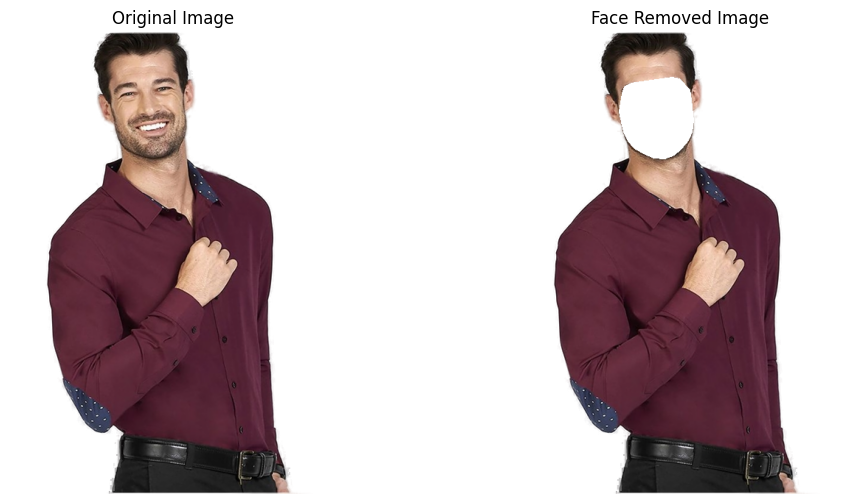

In [14]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt

# Cargar el modelo pre-entrenado
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("C:\\projects\\visual\\Console\\MOPDlib\\MOPDlib\\Models\\shape_predictor_68_face_landmarks.dat")

original = "D:\\tmp\\Andrea\\train\\train\\Camisas\\CAMISASVINO14562710_masked.jpg"

# Cargar la imagen
img = cv2.imread(original, cv2.IMREAD_UNCHANGED)

# Detectar la cara
faces = detector(img[:, :, :3])

# Eliminar la cara de la imagen
for face in faces:
    landmarks = predictor(img[:, :, :3], face)

    # Unir los puntos de referencia faciales para crear la máscara
    points = []
    for n in range(1, 18):  # puntos de la barbilla
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        points.append((x, y))
    for n in range(18, 22):  # puntos de la ceja izquierda
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        points.append((x, y))
    for n in range(22, 23):  # puntos que unen las cejas
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        points.append((x, y))
    for n in range(22, 27):  # puntos de la ceja derecha
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        points.append((x, y))
    for n in range(27, 18, -1):  # puntos de la oreja derecha a la izquierda
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        points.append((x, y))

    # Rellenar la máscara con un color transparente
    hull = cv2.convexHull(np.array(points))
    mask = np.zeros(img.shape, dtype=np.uint8)
    cv2.drawContours(mask, [hull], 0, (0, 0, 0, 255), -1)

    # Eliminar la cara de la imagen
    img[mask[:, :, 3] == 255, 3] = 0
    break

# Liberar la memoria
del detector
del predictor

# Guardar la imagen sin la cara
#cv2.imwrite("img_sin_cara2.png", img)
from PIL import Image

# Save the faceless image with transparency
faceless = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGBA))
faceless.save("img_sin_cara2.png")


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image on the first subplot
orig = Image.open(original)
axs[0].imshow(orig)
axs[0].set_title('Original Image')

# Display the image with the face removed on the second subplot
faceless = Image.open("img_sin_cara2.png")
axs[1].imshow(faceless)
axs[1].set_title('Face Removed Image')

# Remove the axis ticks and frames
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
plt.savefig('images/faceless.png')

# Show the plot
plt.show()

In [3]:

# Cargar el modelo pre-entrenado


img = cv2.imread("D:\\tmp\\Andrea\\train\\train\\Camisas\\CAMISASVINO14562710_masked.jpg", cv2.IMREAD_UNCHANGED)

extract_primary_colors(img,4)

array([[ 89,  48,  61],
       [ 74,  33,  47],
       [131,  95,  85],
       [199, 158, 138]])

## Test colour detection

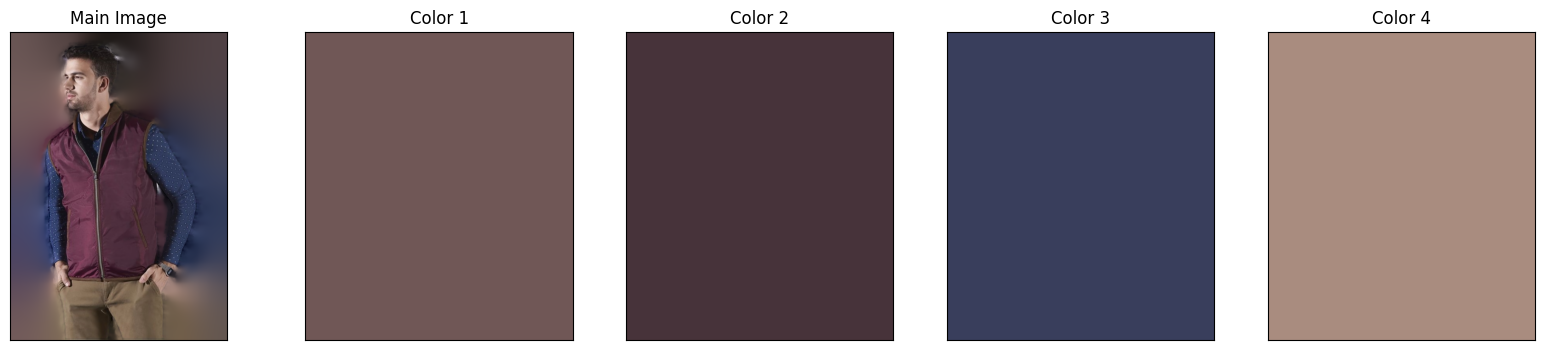

In [9]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Read the main image
#img = cv2.imread("D:\\tmp\\Andrea\\train\\train\\Camisas\\CAMISASVINO14562710_masked.jpg", cv2.IMREAD_UNCHANGED)
img = cv2.imread("test/Chalecos y sacos/CHALECOSMULTICOLOR14718781_masked.jpg")
#img = cv2.imread("test/Chamarras y abrigos/CHAMARRAABRIGOSGRIS14625310_masked.jpg")

# Extract the dominant colors
dominant_colors = extract_primary_colors(img, 4)

# Create a figure with a size that can fit all the images
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

# Plot the main image
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Main Image")
axs[0].set_xticks([])
axs[0].set_yticks([])

# Plot each dominant color
for i, color in enumerate(dominant_colors):
    axs[i+1].set_facecolor(color/255)  # Normalize the RGB values to [0, 1]
    axs[i+1].set_title(f"Color {i+1}")
    axs[i+1].set_xticks([])
    axs[i+1].set_yticks([])

plt.savefig('images/colour_comparison.png')

plt.show()

# Utilities

## Create test dataset with 30% of the original dataset

In [ ]:
import os
import shutil
import random

# Define source and destination root folders
src_root = 'D:\\tmp\\Andrea\\train\\train\\ZapatoDeportivo'
dst_root = 'D:\\tmp\\Andrea\\test\\ZapatoDeportivo'

# Create destination root folder if it doesn't exist
if not os.path.exists(dst_root):
    os.makedirs(dst_root)

# Iterate through subfolders
for subfolder in os.listdir(src_root):
    src_subfolder = os.path.join(src_root, subfolder)
    dst_subfolder = os.path.join(dst_root, subfolder)

    # Create destination subfolder if it doesn't exist
    if not os.path.exists(dst_subfolder):
        os.makedirs(dst_subfolder)

    # Get list of image files in subfolder
    image_files = [f for f in os.listdir(src_subfolder) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Calculate number of images to move (30% of total)
    num_images_to_move = int(len(image_files) * 0.3)

    # Randomly select images to move
    images_to_move = random.sample(image_files, num_images_to_move)

    # Move selected images to destination subfolder
    for image in images_to_move:
        src_image = os.path.join(src_subfolder, image)
        dst_image = os.path.join(dst_subfolder, image)
        shutil.move(src_image, dst_image)

    print(f"Moved {num_images_to_move} images to {dst_subfolder}")

## Remove special characters from files

In [29]:
import os
import unicodedata

# Define the directory path
root_dir = 'D:\\tmp\\Andrea\\train\\train\\ZapatoDeportivo'

# Function to replace special characters
def replace_special_chars(filename):
    # Normalize filename and encode to ASCII
    filename = unicodedata.normalize('NFKD', filename).encode('ascii', 'ignore').decode()
    
    # Replace remaining special characters
    return ''.join(e for e in filename if e.isalnum() or e in ['_'])

# Walk through directories and rename files
for dir_path, dir_names, file_names in os.walk(root_dir):
    for file_name in file_names:
        new_file_name = replace_special_chars(file_name)
        if file_name != new_file_name:
            os.rename(os.path.join(dir_path, file_name), os.path.join(dir_path, new_file_name))
            print(f"Renamed '{file_name}' to '{new_file_name}'")

print("File renaming complete.")

Renamed 'ADIDASARGECYROJO26715430..jpg' to 'ADIDASARGECYROJO26715430jpg'
Renamed 'ADIDASARGECYROJO26715431..jpg' to 'ADIDASARGECYROJO26715431jpg'
Renamed 'ADIDASARGECYROJO26715432..jpg' to 'ADIDASARGECYROJO26715432jpg'
Renamed 'ADIDASARGECYROJO26715433..jpg' to 'ADIDASARGECYROJO26715433jpg'
Renamed 'ADIDASARGECYROJO26715434..jpg' to 'ADIDASARGECYROJO26715434jpg'
Renamed 'ADIDASARGECYROJO26715435..jpg' to 'ADIDASARGECYROJO26715435jpg'
Renamed 'ADIDASARGECYROJO26715436..jpg' to 'ADIDASARGECYROJO26715436jpg'
Renamed 'ADIDASARGECYROJO26715437..jpg' to 'ADIDASARGECYROJO26715437jpg'
Renamed 'ADIDASCOURTSMASHBLANCO27399460..jpg' to 'ADIDASCOURTSMASHBLANCO27399460jpg'
Renamed 'ADIDASCRAZYTRAIN2CFMVERDE25546480..jpg' to 'ADIDASCRAZYTRAIN2CFMVERDE25546480jpg'
Renamed 'ADIDASCRAZYTRAIN2CFMVERDE25546481..jpg' to 'ADIDASCRAZYTRAIN2CFMVERDE25546481jpg'
Renamed 'ADIDASCRAZYTRAIN2CFMVERDE25546482..jpg' to 'ADIDASCRAZYTRAIN2CFMVERDE25546482jpg'
Renamed 'ADIDASDURAMO8TRAINERMAZUL25978290..jpg' to 'ADIDA

## Add extension to files

In [30]:
import os

# Define the directory path
root_dir = 'D:\\tmp\\Andrea\\train\\train\\ZapatoDeportivo'

# Walk through directories and rename files
for dir_path, dir_names, file_names in os.walk(root_dir):
    for file_name in file_names:
        # Check if file name ends with 'jpg', 'png', etc.
        if file_name.endswith('jpg') or file_name.endswith('png') or file_name.endswith('jpeg'):
            # Insert '.' before the extension
            new_file_name = file_name[:-3] + '.' + file_name[-3:]
            os.rename(os.path.join(dir_path, file_name), os.path.join(dir_path, new_file_name))
            print(f"Renamed '{file_name}' to '{new_file_name}'")

print("File renaming complete.")

Renamed 'ADIDASARGECYROJO26715430jpg' to 'ADIDASARGECYROJO26715430.jpg'
Renamed 'ADIDASARGECYROJO26715431jpg' to 'ADIDASARGECYROJO26715431.jpg'
Renamed 'ADIDASARGECYROJO26715432jpg' to 'ADIDASARGECYROJO26715432.jpg'
Renamed 'ADIDASARGECYROJO26715433jpg' to 'ADIDASARGECYROJO26715433.jpg'
Renamed 'ADIDASARGECYROJO26715434jpg' to 'ADIDASARGECYROJO26715434.jpg'
Renamed 'ADIDASARGECYROJO26715435jpg' to 'ADIDASARGECYROJO26715435.jpg'
Renamed 'ADIDASARGECYROJO26715436jpg' to 'ADIDASARGECYROJO26715436.jpg'
Renamed 'ADIDASARGECYROJO26715437jpg' to 'ADIDASARGECYROJO26715437.jpg'
Renamed 'ADIDASCOURTSMASHBLANCO27399460jpg' to 'ADIDASCOURTSMASHBLANCO27399460.jpg'
Renamed 'ADIDASCRAZYTRAIN2CFMVERDE25546480jpg' to 'ADIDASCRAZYTRAIN2CFMVERDE25546480.jpg'
Renamed 'ADIDASCRAZYTRAIN2CFMVERDE25546481jpg' to 'ADIDASCRAZYTRAIN2CFMVERDE25546481.jpg'
Renamed 'ADIDASCRAZYTRAIN2CFMVERDE25546482jpg' to 'ADIDASCRAZYTRAIN2CFMVERDE25546482.jpg'
Renamed 'ADIDASDURAMO8TRAINERMAZUL25978290jpg' to 'ADIDASDURAMO8TRAINE